---

# Loan Performance Case Study

### Imports

In [111]:
import numpy as np
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import math
from dateutil.relativedelta import relativedelta
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import signature
from sklearn import metrics
from collections import defaultdict

### Read In Data

In [2]:
df = pd.read_csv("loan.csv", usecols=["loan_amnt", "funded_amnt", "term", "int_rate", "grade", "annual_inc",\
                                        "issue_d", "dti", "revol_bal", "total_pymnt", "loan_status"])  

### Data / Data Types

First we can take a quick look at our data.

In [3]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,Fully Paid,27.65,13648.0,5861.071414
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,Charged Off,1.00,1687.0,1008.710000
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,Fully Paid,8.72,2956.0,3003.653644
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,Fully Paid,20.00,5598.0,12226.302212
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,Current,17.94,27783.0,3242.170000


In [4]:
df.shape

(887379, 11)

And the associated inferred datatypes from Pandas.

In [5]:
df.dtypes

loan_amnt      float64
funded_amnt    float64
term            object
int_rate       float64
grade           object
annual_inc     float64
issue_d         object
loan_status     object
dti            float64
revol_bal      float64
total_pymnt    float64
dtype: object

Based on the data these inferred types seem reasonable, as we have float types inferred for apparent numeric columns and object (String) types inferred for the apparent string columns displayed above. One small change we will make, for ease of analysis, is to convert the 'issue_d' column to datetime.

In [6]:
df["issue_d"] = pd.to_datetime(df["issue_d"])

In [7]:
df.dtypes

loan_amnt             float64
funded_amnt           float64
term                   object
int_rate              float64
grade                  object
annual_inc            float64
issue_d        datetime64[ns]
loan_status            object
dti                   float64
revol_bal             float64
total_pymnt           float64
dtype: object

## 1. Exploratory Data Analysis

### Step 1 - Checking NULL / Empty Strings / Missing Values

First we will check numeric columns for NULL values.

In [8]:
df.isna().sum()

loan_amnt      0
funded_amnt    0
term           0
int_rate       0
grade          0
annual_inc     4
issue_d        0
loan_status    0
dti            0
revol_bal      0
total_pymnt    0
dtype: int64

Next we will check all values of object (String/str) columns for blank or odd values.

In [9]:
df["term"].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [10]:
df["grade"].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [11]:
df["issue_d"].unique()

array(['2011-12-01T00:00:00.000000000', '2011-11-01T00:00:00.000000000',
       '2011-10-01T00:00:00.000000000', '2011-09-01T00:00:00.000000000',
       '2011-08-01T00:00:00.000000000', '2011-07-01T00:00:00.000000000',
       '2011-06-01T00:00:00.000000000', '2011-05-01T00:00:00.000000000',
       '2011-04-01T00:00:00.000000000', '2011-03-01T00:00:00.000000000',
       '2011-02-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2010-12-01T00:00:00.000000000', '2010-11-01T00:00:00.000000000',
       '2010-10-01T00:00:00.000000000', '2010-09-01T00:00:00.000000000',
       '2010-08-01T00:00:00.000000000', '2010-07-01T00:00:00.000000000',
       '2010-06-01T00:00:00.000000000', '2010-05-01T00:00:00.000000000',
       '2010-04-01T00:00:00.000000000', '2010-03-01T00:00:00.000000000',
       '2010-02-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2009-12-01T00:00:00.000000000', '2009-11-01T00:00:00.000000000',
       '2009-10-01T00:00:00.000000000', '2009-09-01

In [12]:
df["loan_status"].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

Based on the above analysis, it appears there are missing values in the 'annual_inc' column. All other columns appear to have no NULL, blank, or otherwise missing values.
We can take a close look at the rows corresponding to NULL values in the 'annual_inc' column.

In [13]:
df[df.isnull().any(axis=1)]

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
42449,5000.0,5000.0,36 months,7.43,A,NaN,2007-08-01,Does not meet the credit policy. Status:Fully ...,1.0,0.0,5593.46
42450,7000.0,7000.0,36 months,7.75,A,NaN,2007-08-01,Does not meet the credit policy. Status:Fully ...,1.0,0.0,7867.53
42480,6700.0,6700.0,36 months,7.75,A,NaN,2007-07-01,Does not meet the credit policy. Status:Fully ...,1.0,0.0,7530.42
42533,6500.0,6500.0,36 months,8.38,A,NaN,2007-06-01,Does not meet the credit policy. Status:Fully ...,4.0,0.0,7373.83


These NULL/NaN values are clustered in the mid-2007 period. This could also be due to internal issues with the LendingClub database or lack of requirements for reporting annual income within the database / front end. We will avoid dropping these records for now. If there is a business case to fill in these values then additional techniques such as imputation (using mean, MICE, or other methods) could be explored at a later time.

In [14]:
df.shape

(887379, 11)

### Step 2 - Initial EDA

In [15]:
df_desc = df.describe()
display(df_desc)

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
count,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,8.873790e+05,887379.000000
mean,14755.264605,14741.877625,13.246740,7.502759e+04,18.157039,1.692079e+04,7558.826684
std,8435.455601,8429.897657,4.381867,6.469830e+04,17.190626,2.242679e+04,7871.243336
min,500.000000,500.000000,5.320000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,8000.000000,8000.000000,9.990000,4.500000e+04,11.910000,6.443000e+03,1914.590000
50%,13000.000000,13000.000000,12.990000,6.500000e+04,17.650000,1.187500e+04,4894.999117
75%,20000.000000,20000.000000,16.200000,9.000000e+04,23.950000,2.082900e+04,10616.814231
max,35000.000000,35000.000000,28.990000,9.500000e+06,9999.000000,2.904836e+06,57777.579870


Initial Observations:

1. Loan application amount and funded amount appear to have very similar distributions, we will verify this later.
2. Interest rates seem have somewhat higher variance than expected.
3. Annual income seems to be right skewed as expected.
4. Debt-to-income seems to have relatively high variance.

In [16]:
df.corr()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
loan_amnt,1.000000,0.999263,0.145023,0.332698,0.020675,0.333580,0.474626
funded_amnt,0.999263,1.000000,0.145160,0.332466,0.021075,0.333435,0.473286
int_rate,0.145023,0.145160,1.000000,-0.072786,0.079903,-0.035708,0.170506
annual_inc,0.332698,0.332466,-0.072786,1.000000,-0.087410,0.295784,0.160879
dti,0.020675,0.021075,0.079903,-0.087410,1.000000,0.067277,-0.041529
revol_bal,0.333580,0.333435,-0.035708,0.295784,0.067277,1.000000,0.138328
total_pymnt,0.474626,0.473286,0.170506,0.160879,-0.041529,0.138328,1.000000


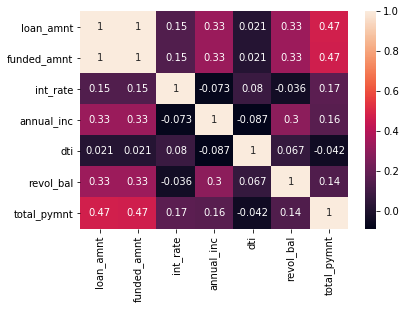

In [17]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)

Correlation Observations:

1. Loan application amount and funding amount appear to be highly correlated (approaching 1.0).
2. Loan application amount, funding amount, annual income, revolving balance, and total payment all appear to be moderate-highly positively correlated.

All of these correlations seem reasonable and conform to my expectations about the loan application process, credit requirements, and nature of these fields.

Next we will plot distributions for the numeric columns.

/Users/Samuel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


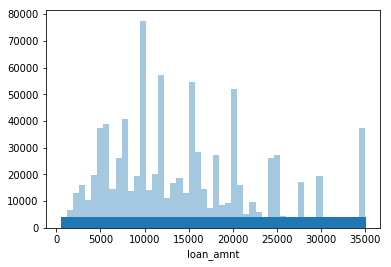

In [18]:
sns.distplot(df["loan_amnt"], kde=False, rug=True);

In [19]:
df.groupby(["loan_amnt"]).size().reset_index(name='count').sort_values(['count'], ascending=False).head(20)

,loan_amnt,count
371,10000.0,61837
451,12000.0,50183
571,15000.0,47210
771,20000.0,46932
1371,35000.0,36368
291,8000.0,27870
171,5000.0,27167
211,6000.0,26207
971,25000.0,24125
611,16000.0,23708


Loan application amount appears to be reasonably normally distribution in most cases. There are several values, including 10,000; 12,000; 15,000; 25,000; and 35,000 dollars, along with others that appear to be overly represented based on standard distributional assumptions. This is likely due to human preference for these numbers. 

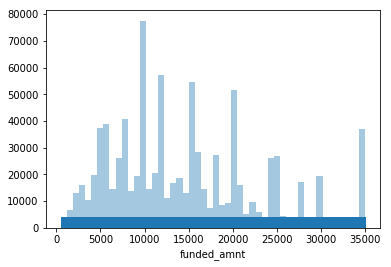

In [20]:
sns.distplot(df["funded_amnt"], kde=False, rug=True)
plt.show()

The distribution of funding amount closely mimics the distribution of loan application amount as expected.

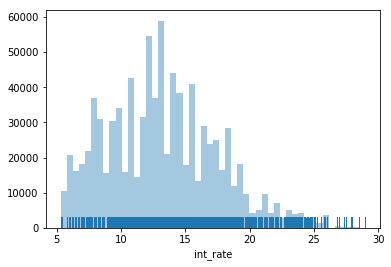

In [21]:
sns.distplot(df["int_rate"], kde=False, rug=True)
plt.show()

In [22]:
df.groupby(["int_rate"]).size().reset_index(name='count').sort_values(['count'], ascending=False).head()

,int_rate,count
110,10.99,34624
59,9.17,25720
287,15.61,25201
80,9.99,21553
38,7.89,20311


Interest rates appear to be reasonably distributed at first glance with no observable outliers. It is interesting to note the changes in density between different rate values in the plot.

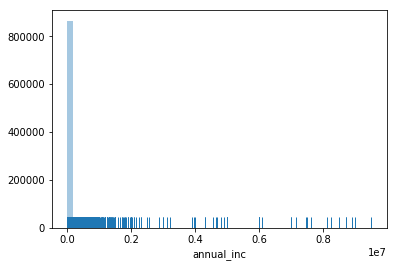

In [23]:
sns.distplot(df["annual_inc"].dropna(), kde=False, rug=True)
plt.show()

323491.50071200065


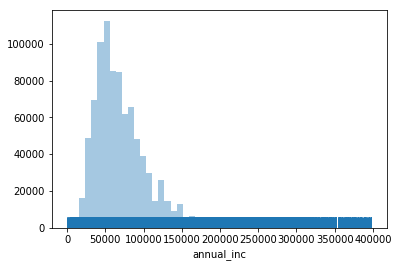

In [24]:
thresh = 5*df_desc["annual_inc"]["std"]
print(thresh)
sns.distplot(df[abs(df["annual_inc"]-df_desc["annual_inc"]["mean"]) < thresh]["annual_inc"], kde=False, rug=True)
plt.show()

In [25]:
df.groupby(["annual_inc"]).size().reset_index(name='count').sort_values(['count'], ascending=False).head()

,annual_inc,count
24048,60000.0,34281
17805,50000.0,30575
26762,65000.0,25498
29378,70000.0,24121
11305,40000.0,23943


It appears there are some outliers for annual income and the distribution appears to be right skewed.

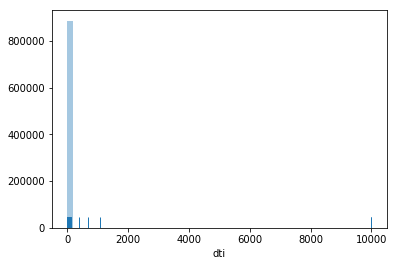

In [26]:
sns.distplot(df["dti"], kde=False, rug=True)
plt.show()

85.95312843970368


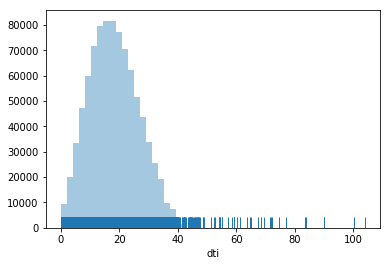

In [27]:
thresh = 5*df_desc["dti"]["std"]
print(thresh)
sns.distplot(df[abs(df["dti"]-df_desc["dti"]["mean"]) < thresh]["dti"], kde=False, rug=True)
plt.show()

In [28]:
df.groupby(["dti"]).size().reset_index(name='count').sort_values(['count'], ascending=False).head()

,dti,count
1920,19.2,684
1440,14.4,674
1800,18.0,661
1320,13.2,638
1680,16.8,632


There appear to be some outliers for the 'debt-to-income' variable.

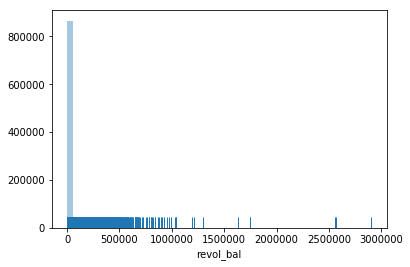

In [29]:
sns.distplot(df["revol_bal"], kde=False, rug=True)
plt.show()

112133.95947981573


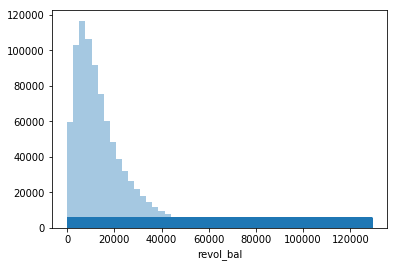

In [30]:
thresh = 5*df_desc["revol_bal"]["std"]
print(thresh)
sns.distplot(df[abs(df["revol_bal"]-df_desc["revol_bal"]["mean"]) < thresh]["revol_bal"], kde=False, rug=True)
plt.show()

In [31]:
df.groupby(["revol_bal"]).size().reset_index(name='count').sort_values(['count'], ascending=False).head()

,revol_bal,count
0,0.0,3402
5235,5235.0,74
5466,5466.0,72
4479,4479.0,68
6969,6969.0,67


The appears to be some right-skew and outliers for the revolving balance variable.

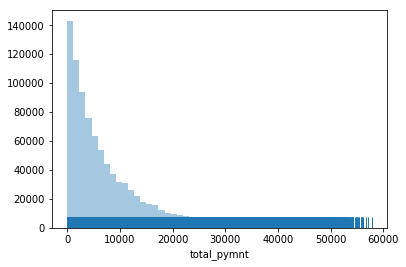

In [32]:
sns.distplot(df["total_pymnt"], kde=False, rug=True)
plt.show()

In [33]:
df.groupby(["total_pymnt"]).size().reset_index(name='count').sort_values(['count'], ascending=False).head()

,total_pymnt,count
0,0.00,17759
23309,648.57,135
35679,938.06,134
22207,623.86,131
61829,1566.46,117


There appears to be a large right skew for the total payment distribution.

Now we will explore our categorical variables.

In [34]:
df["term"].value_counts()

 36 months    621125
 60 months    266254
Name: term, dtype: int64

A 36 month loan term appears to be most common, representing 70.00% of the dataset.

In [35]:
df["grade"].value_counts()

B    254535
C    245860
A    148202
D    139542
E     70705
F     23046
G      5489
Name: grade, dtype: int64

B grade loans are the most common, closely followed by C grade loans. The next most common grades, A and D grades, also have similar counts.

In [36]:
df["issue_d"].value_counts()

2015-10-01    48631
2015-07-01    45962
2015-12-01    44342
2014-10-01    38782
2015-11-01    37530
2015-08-01    35886
2015-04-01    35427
2015-01-01    35107
2015-05-01    31913
2014-07-01    29306
2015-09-01    28641
2015-06-01    28485
2015-03-01    25400
2014-11-01    25054
2015-02-01    23770
2014-05-01    19099
2014-04-01    19071
2014-08-01    18814
2014-06-01    17179
2014-03-01    16513
2014-01-01    15628
2014-02-01    15269
2013-12-01    15020
2013-11-01    14676
2013-10-01    14114
2013-09-01    12987
2013-08-01    12674
2013-07-01    11910
2013-06-01    10899
2014-09-01    10606
              ...  
2009-12-01      658
2009-10-01      604
2009-09-01      507
2009-08-01      446
2009-07-01      411
2009-06-01      406
2008-03-01      402
2009-05-01      359
2009-04-01      333
2009-03-01      324
2008-02-01      306
2008-01-01      305
2009-02-01      302
2009-01-01      269
2008-04-01      259
2008-12-01      253
2008-11-01      209
2007-12-01      172
2008-07-01      141


It appears that loan volumes have increased over time. We can look at this relationship below.

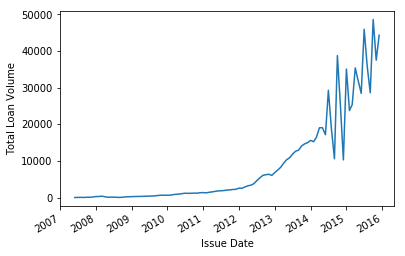

In [37]:
count_df = df.groupby(["issue_d"]).size().reset_index(name="count").sort_values(["count"], ascending=False)
count_df[["issue_d","count"]].set_index("issue_d").plot(legend=False)
plt.xlabel("Issue Date")
plt.ylabel("Total Loan Volume")
plt.show()

Loan volumes have indeed trended up over time. Interestingly, it appears that loan volumes have gotten much more variable during and after 2015.

In [38]:
df["loan_status"].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

The most common loan status is 'Current' followed by 'Fully Paid'. The other categories aside from 'Issued' represent loans which are at risk of default, are in default, or are charged off. 7.82% of all loans are in these categories.

In [39]:
loan_status_agg = (df.groupby(["loan_status", "grade"]).size()/df.groupby(["grade"]).size())
(loan_status_agg["Current"]+loan_status_agg["Fully Paid"])*100

grade
A    96.490601
B    93.614238
C    91.048971
D    87.431741
E    84.844070
F    79.471492
G    73.947896
dtype: float64

There appears to be a correlation between grades and associated loan status- 96.491% of A grade loans are "Current" or "Fully Paid" while only 73.948% of G grade loans are "Current" or "Fully Paid".

In [40]:
df["year"] = df["issue_d"].apply(lambda x: x.year)
df_grade_agg = df.groupby(["grade", "year"]).size()/df.groupby(["year"]).size()
df_grade_agg.head()

grade  year
A      2007    0.129353
       2008    0.132888
       2009    0.227798
       2010    0.225732
       2011    0.264905
dtype: float64

In [41]:
df_year_agg = df.groupby(["year", "grade"]).size()/df.groupby(["year"]).size()
df_year_agg.head()

year  grade
2007  A        0.129353
      B        0.162521
      C        0.233831
      D        0.164179
      E        0.165837
dtype: float64

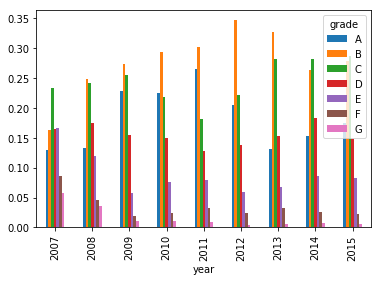

In [42]:
df_grade_agg.unstack(level=0).plot(kind='bar', subplots=False)
plt.show()

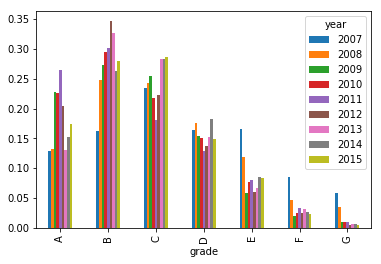

In [43]:
df_year_agg.unstack(level=0).plot(kind='bar', subplots=False)
plt.show()

Some interesting trends appear in the data:
1. We see that grade A loans peaked in popularity around 2011 (this may be due to tighter standards / more limited risk appetites after the financial crisis.)
2. Grade B loans peaked in popularity around 2012.
3. Grade C loans are now the most popular.
4. Grade F and G loans were more popular in 2007 than any time after.

### Step 3 - Discussion of Outliers

Based on the above EDA there are apparent outliers in the following columns:

1. Annual Income
2. Debt to Income
3. Revolving Balance

We can initially quantify outliers using a 4 standard deviation cutoff from the mean, and will check for the presence of outliers in other columns.

In [44]:
thresh1 = 4*df_desc["loan_amnt"]["std"]
len(df[abs(df["loan_amnt"]-df_desc["loan_amnt"]["mean"]) >= thresh1])

0

In [45]:
thresh2 = 4*df_desc["funded_amnt"]["std"]
len(df[abs(df["funded_amnt"]-df_desc["funded_amnt"]["mean"]) >= thresh2])

0

In [46]:
thresh3 = 4*df_desc["int_rate"]["std"]
len(df[abs(df["int_rate"]-df_desc["int_rate"]["mean"]) >= thresh3])

0

In [47]:
thresh4 = 4*df_desc["annual_inc"]["std"]
len(df[abs(df["annual_inc"]-df_desc["annual_inc"]["mean"]) >= thresh4])

3641

In [48]:
thresh5 = 4*df_desc["dti"]["std"]
len(df[abs(df["dti"]-df_desc["dti"]["mean"]) >= thresh5])

13

In [49]:
thresh6 = 4*df_desc["revol_bal"]["std"]
len(df[abs(df["revol_bal"]-df_desc["revol_bal"]["mean"]) >= thresh6])

6893

In [50]:
thresh7 = 4*df_desc["total_pymnt"]["std"]
len(df[abs(df["total_pymnt"]-df_desc["total_pymnt"]["mean"]) >= thresh7])

5526

Based on this rule, total payments appears to have outlier values as well.

In [51]:
len(df[(abs(df["annual_inc"]-df_desc["annual_inc"]["mean"] >= thresh4)) | (abs(df["dti"]-df_desc["dti"]["mean"] >= thresh5)) | (abs(df["revol_bal"]-df_desc["revol_bal"]["mean"]) >= thresh6) | (abs(df["total_pymnt"]-df_desc["total_pymnt"]["mean"]) >= thresh7)])

15103

Given a somewhat crude rule of [abs(value-mean) > 4*sd] representing an outlier for a given numeric attribute, we can identify 15,103 records corresponding to this rule when when considering all numeric attributes.
If there was time to further dive into working on outlier detection we could look at techniques such as one-class SVM or isolation forests. We will not exclude the idenfitied outliers for now and will deal with them later during the modeling phase.

### Step 4 - Summary of Findings

Note: The two(+) data visualizations and summary statistics to support the findings below can be found above.

Based on our exploratory data analysis, there are several important findings:
    
1. Four records with NULL or otherwise blank values were found.
2. Loan amount and funding amount appear to be highly correlated.
3. Loan amount, funding amount, annual incoming, revolving balance, and total payments all appear to be moderately-highly correlated.
4. Approximately 15,103 outliers were found in our numeric data using a 4 standard deviation cutoff.
5. Total loan volumes have trended up over time.
6. Loans that are in good standing make up the bulk of the loan portfolio (92.18%).
7. Higher grade loans appear to have better payback characteristics.
8. There appear to be time trends in the distribution of loan grades, potentially due to lender demand or regulatory requirements.

# 2. Business Analysis

We will subset to include only loans with 36 month terms.

In [52]:
ba_df = copy.deepcopy(df)
ba_df = ba_df[ba_df.term == " 36 months"]

In [53]:
ba_df.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,year
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414,2011
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644,2011
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212,2011
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753,2011
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334,2011


In [54]:
ba_df.shape

(621125, 12)

Now we will exclude loans with less than 36 months of data. We can utilize a date difference from the maximum date (12/2015) to the loan issue date.

In [55]:
end_date = max(ba_df["issue_d"])
print(end_date)

2015-12-01 00:00:00


In [56]:
ba_df["months_diff"] = ((end_date - ba_df["issue_d"])/np.timedelta64(1, 'M')).astype(int)

In [57]:
ba_df.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,year,months_diff
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414,2011,48
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644,2011,48
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212,2011,48
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753,2011,48
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334,2011,48


In [58]:
ba_df_valid = copy.deepcopy(ba_df[ba_df["months_diff"] >= 36])

In [59]:
ba_df_valid.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,year,months_diff
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414,2011,48
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644,2011,48
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212,2011,48
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753,2011,48
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334,2011,48


In [60]:
ba_df_valid.shape

(70200, 13)

### Question 1

In [61]:
def default_check(row):
    if row["loan_status"] == "Fully Paid":
        return 0 
    else:
        return 1

ba_df_valid["default_flag"] = ba_df_valid.apply(default_check, axis=1)

In [62]:
len(ba_df_valid[ba_df_valid["default_flag"] == 0]) / len(ba_df_valid)

0.8432336182336182

84.323% of matured 36-month loans have been fully paid.

### Question 2

In [63]:
ba_df_valid["year"] = ba_df["issue_d"].apply(lambda x: x.year)
ba_df_valid["month"] = ba_df["issue_d"].apply(lambda x: x.month)

# Setting model_df here to avoid duplicating transformations.
model_df = copy.deepcopy(ba_df_valid.drop(["months_diff", "loan_status", "term"], axis=1))

In [64]:
grp_default_df = ba_df_valid[ba_df_valid["default_flag"] == 1].groupby(["year", "grade"]).size()

In [65]:
grp_df = ba_df_valid.groupby(["year", "grade"]).size()

In [66]:
grp_delta_df = grp_default_df / grp_df
display(grp_delta_df)

year  grade
2007  A        0.282051
      B        0.459184
      C        0.567376
      D        0.777778
      E        0.910000
      F        0.903846
      G        1.000000
2008  A        0.125786
      B        0.271044
      C        0.379310
      D        0.599045
      E        0.778947
      F        0.900901
      G        0.976744
2009  A        0.086451
      B        0.163322
      C        0.245549
      D        0.334149
      E        0.399351
      F        0.495238
      G        0.727273
2010  A        0.053370
      B        0.134403
      C        0.224155
      D        0.294493
      E        0.348214
      F        0.505495
      G        0.647059
2011  A        0.063990
      B        0.105676
      C        0.155243
      D        0.180809
      E        0.205882
      F        0.240741
      G        0.400000
2012  A        0.074203
      B        0.129363
      C        0.178265
      D        0.215827
      E        0.213333
      F        0.197674
    

In [67]:
grp_delta_df.idxmax()

(2007, 'G')

Grade 'G' loans issued in 2007 have the highest rate of default.

### Question 3

In [68]:
ba_df_valid["rate_of_return"] = (((ba_df_valid["total_pymnt"]/ba_df_valid["funded_amnt"])**(1/3)) - 1)

In [69]:
ror_df = ba_df_valid.groupby(["year", "grade"]).agg("mean")["rate_of_return"]
display(ror_df)

year  grade
2007  A        0.027138
      B       -0.001888
      C       -0.008031
      D       -0.014353
      E       -0.015099
      F       -0.079863
      G       -0.044102
2008  A        0.023445
      B       -0.000428
      C       -0.004508
      D       -0.018365
      E       -0.003337
      F       -0.045138
      G       -0.007913
2009  A        0.021337
      B        0.014358
      C        0.011975
      D        0.013982
      E       -0.000270
      F        0.002615
      G        0.002985
2010  A        0.021611
      B        0.021892
      C        0.022227
      D        0.012545
      E        0.013981
      F       -0.007814
      G       -0.007685
2011  A        0.014910
      B        0.021848
      C        0.017563
      D        0.021422
      E        0.024065
      F        0.022267
      G       -0.020399
2012  A        0.014938
      B        0.022425
      C        0.021012
      D        0.022788
      E        0.033121
      F        0.031940
    

In [70]:
ror_df.idxmax()

(2012, 'G')

Interestingly, Grade 'G' loans issued in 2012 have the highest rate of return.

# 3. Logistic Regression Model

Note: For this question I will focus on 36-month loans using the criteria as defined above. 

In [71]:
# Using model_df as set above.
model_df.head()

,loan_amnt,funded_amnt,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,year,default_flag,month
0,5000.0,5000.0,10.65,B,24000.0,2011-12-01,27.65,13648.0,5861.071414,2011,0,12
2,2400.0,2400.0,15.96,C,12252.0,2011-12-01,8.72,2956.0,3003.653644,2011,0,12
3,10000.0,10000.0,13.49,C,49200.0,2011-12-01,20.00,5598.0,12226.302212,2011,0,12
5,5000.0,5000.0,7.90,A,36000.0,2011-12-01,11.20,7963.0,5631.377753,2011,0,12
7,3000.0,3000.0,18.64,E,48000.0,2011-12-01,5.35,8221.0,3938.144334,2011,0,12


In [72]:
model_df.shape

(70200, 12)

### Dealing with NULL/NaN Values and Outliers Identified Above

First we will drop the NULL / NaN values identified above in order to train our logistic regression model. This seems especially reasonable considering the limited number of observations (4). Additional imputation methods could be considered at a later time depending on business requirements. It is also a requirement for scikit's training and testing that no NULL/NaN values are present.

In [73]:
model_df = model_df.dropna()

In [74]:
model_df.head()

,loan_amnt,funded_amnt,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,year,default_flag,month
0,5000.0,5000.0,10.65,B,24000.0,2011-12-01,27.65,13648.0,5861.071414,2011,0,12
2,2400.0,2400.0,15.96,C,12252.0,2011-12-01,8.72,2956.0,3003.653644,2011,0,12
3,10000.0,10000.0,13.49,C,49200.0,2011-12-01,20.00,5598.0,12226.302212,2011,0,12
5,5000.0,5000.0,7.90,A,36000.0,2011-12-01,11.20,7963.0,5631.377753,2011,0,12
7,3000.0,3000.0,18.64,E,48000.0,2011-12-01,5.35,8221.0,3938.144334,2011,0,12


### Relevant Column Selection

Loan application amount, funded amount, interest rate, grade, annual income, issue date, debt-to-income, and revolving balances are variables that should be present at loan issuance.

In [75]:
model_df = model_df[["loan_amnt", "funded_amnt", "int_rate", "grade", "annual_inc", "issue_d", "dti", "revol_bal", "default_flag", "year", "month"]]

In [76]:
model_df.shape

(70196, 11)

### Outlier Removal

We can also exclude records that were identified as outliers above. Additional analysis or methods such as imputation may be needed depending on business requirements / model output requirements regarding dataset completeness.

In [77]:
model_df = model_df[((abs(model_df["annual_inc"]-df_desc["annual_inc"]["mean"] < thresh4)) & (abs(model_df["dti"]-df_desc["dti"]["mean"] < thresh5)) & (abs(model_df["revol_bal"]-df_desc["revol_bal"]["mean"]) < thresh6))]

In [78]:
model_df.shape

(69636, 11)

### Feature Selection

Since loan application amount is extremely highly correlated with funding amount and wouldn't seem to have a long term bearing on defaults we will exclude that column from consideration for our regression modeling. 

In [79]:
model_df = model_df[["funded_amnt", "int_rate", "grade", "annual_inc", "issue_d", "dti", "revol_bal", "default_flag", "year"]]

Because we are using L2 regularization we do not need to be as concerned about multicollinearity in this case. A deep dive into multicollinearity and some PCA / factor analysis would be a next step here and will help with regression coefficient interpretation.

Next we will need to one-hot encode our categorical variables in order to perform logistic regression.

In [80]:
model_df_one_hot = pd.concat([model_df[["funded_amnt", "int_rate", "annual_inc", "revol_bal", "dti", "default_flag"]],
                           pd.get_dummies(model_df["grade"], prefix="grade"),
                           pd.get_dummies(model_df["year"], prefix="year")],axis=1)

In [81]:
model_df_one_hot.corr()

,funded_amnt,int_rate,annual_inc,revol_bal,dti,default_flag,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012
funded_amnt,1.000000,0.193897,0.411876,0.332515,0.051064,-0.027009,-0.093148,-0.018733,-0.011272,0.100831,0.105750,0.047839,0.024373,-0.038301,-0.063426,-0.032857,-0.056839,-0.085263,0.154434
int_rate,0.193897,1.000000,0.025042,0.093209,0.155424,0.175632,-0.771472,-0.054535,0.359583,0.491458,0.277830,0.154211,0.119593,-0.003857,0.004279,0.036938,-0.071214,-0.194544,0.184689
annual_inc,0.411876,0.025042,1.000000,0.394318,-0.171021,-0.075310,0.019019,-0.034928,-0.025183,0.021496,0.048020,0.027796,0.023640,-0.017830,-0.018113,0.002861,0.002612,0.007921,0.000150
revol_bal,0.332515,0.093209,0.394318,1.000000,0.238943,-0.007097,-0.069182,0.015718,0.006638,0.029918,0.038999,0.034636,0.031992,-0.022314,0.014716,0.011979,-0.019971,-0.049317,0.045702
dti,0.051064,0.155424,-0.171021,0.238943,1.000000,0.037826,-0.129491,0.057536,0.052748,0.023116,-0.002711,0.007779,0.021610,-0.052788,-0.044663,-0.094106,-0.104124,-0.094660,0.222112
default_flag,-0.027009,0.175632,-0.075310,-0.007097,0.037826,1.000000,-0.145737,-0.048959,0.061076,0.103989,0.103938,0.089157,0.096722,0.125294,0.147329,0.042324,0.007854,-0.066537,-0.050162
grade_A,-0.093148,-0.771472,0.019019,-0.069182,-0.129491,-0.145737,1.000000,-0.456108,-0.324911,-0.226943,-0.105188,-0.051861,-0.035330,-0.031406,-0.059744,-0.031797,0.003678,0.131843,-0.064681
grade_B,-0.018733,-0.054535,-0.034928,0.015718,0.057536,-0.048959,-0.456108,1.000000,-0.384847,-0.268807,-0.124592,-0.061428,-0.041848,-0.035488,-0.039969,-0.045893,-0.035975,-0.016968,0.083132
grade_C,-0.011272,0.359583,-0.025183,0.006638,0.052748,0.061076,-0.324911,-0.384847,1.000000,-0.191486,-0.088754,-0.043758,-0.029811,0.005550,0.012284,0.028630,0.009628,-0.071865,0.030890
grade_D,0.100831,0.491458,0.021496,0.029918,0.023116,0.103989,-0.226943,-0.268807,-0.191486,1.000000,-0.061993,-0.030564,-0.020822,0.013088,0.033379,0.032054,0.021977,-0.044172,-0.010602


In [82]:
predictors = model_df_one_hot.drop("default_flag", axis=1)
target = model_df_one_hot["default_flag"]

In [83]:
predictors.head()

,funded_amnt,int_rate,annual_inc,revol_bal,dti,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012
0,5000.0,10.65,24000.0,13648.0,27.65,0,1,0,0,0,0,0,0,0,0,0,1,0
2,2400.0,15.96,12252.0,2956.0,8.72,0,0,1,0,0,0,0,0,0,0,0,1,0
3,10000.0,13.49,49200.0,5598.0,20.00,0,0,1,0,0,0,0,0,0,0,0,1,0
5,5000.0,7.90,36000.0,7963.0,11.20,1,0,0,0,0,0,0,0,0,0,0,1,0
7,3000.0,18.64,48000.0,8221.0,5.35,0,0,0,0,1,0,0,0,0,0,0,1,0


In [84]:
target.head()

0    0
2    0
3    0
5    0
7    0
Name: default_flag, dtype: int64

### Scaling

We now need to scale our numerical predictors to be mean 0 and unit variance. This is especially critical due to the regularization encorporated in the sklearn logistic regression method and is generally best practice for preprocessing.

In [85]:
scalar = StandardScaler()
scaled_predictors = copy.deepcopy(predictors)
scaled_predictors[["funded_amnt", "int_rate", "annual_inc", "dti", "revol_bal"]] = scalar.fit_transform(scaled_predictors[["funded_amnt", "int_rate", "annual_inc", "dti", "revol_bal"]])

In [86]:
scaled_predictors.describe()

,funded_amnt,int_rate,annual_inc,revol_bal,dti,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012
count,6.963600e+04,6.963600e+04,6.963600e+04,6.963600e+04,6.963600e+04,69636.000000,69636.000000,69636.000000,69636.000000,69636.000000,69636.000000,69636.000000,69636.000000,69636.000000,69636.000000,69636.000000,69636.000000,69636.000000
mean,5.685121e-15,6.983701e-15,-8.190677e-17,-6.309718e-16,1.865279e-17,0.278017,0.350752,0.215162,0.117971,0.027931,0.006936,0.003231,0.008315,0.033488,0.074171,0.129775,0.201189,0.553062
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,0.448025,0.477209,0.410937,0.322576,0.164776,0.082994,0.056751,0.090806,0.179909,0.262052,0.336058,0.400892,0.497180
min,-1.497521e+00,-1.805667e+00,-1.685277e+00,-1.020973e+00,-2.011219e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.326330e-01,-8.446114e-01,-6.590923e-01,-6.381062e-01,-7.582490e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.439690e-01,4.464156e-02,-2.416595e-01,-2.555928e-01,-1.969854e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.271830e-01,6.549674e-01,4.181537e-01,3.111469e-01,7.256029e-01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.676723e+00,3.571275e+00,7.231735e+00,7.347348e+00,2.713073e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Modeling Training and Testing

We will now split our dataset into a train and test set. This is critical to identify how our regresssion performs out of sample. 

In [87]:
predictors_train, predictors_test, target_train, target_test = train_test_split(scaled_predictors, target, test_size=0.33, random_state=0)

Next we can get our class probabilities of our outcome variables for our train and test sets.

In [88]:
target_train.value_counts()/len(target_train)

0    0.846236
1    0.153764
Name: default_flag, dtype: float64

In [89]:
target_test.value_counts()/len(target_test)

0    0.84356
1    0.15644
Name: default_flag, dtype: float64

Next we can build and fit our regression model. A few notes on the fitting:

1. We will use CV to help with hyperparameter selection for regularization.
2. I have found the regularization selection (L1/L2) does not change the resultant coefficients in this case.
In general L2 regularization is preferred, especially in cases of potential multicollinearity, so that is my selection.
3. We will use the balanced class weight parameter which should help in this unbalanced case. Testing showed that removing this parameter increases precision for both classes but drastically reduces recall. If we considered recall as being more important than precision for this case, Ie. a false negative is more damaging than a false positive for the loan default scenario, then this is valuable.

In [90]:
clf = LogisticRegressionCV(cv=5, random_state=0, solver='lbfgs', penalty='l2', class_weight="balanced", max_iter=1000).fit(predictors_train, target_train)

In [91]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
coefficients = pd.concat([pd.DataFrame(predictors.columns),pd.DataFrame(np.transpose(np.exp(clf.coef_)))], axis = 1)
display(coefficients)

,0,0
0,funded_amnt,0.958
1,int_rate,1.144
2,annual_inc,0.775
3,revol_bal,1.014
4,dti,1.073
5,grade_A,0.303
6,grade_B,0.501
7,grade_C,0.724
8,grade_D,0.883
9,grade_E,1.230


In [92]:
clf.score(predictors_train, target_train)

0.6509130658436214

In [93]:
probabilities_train = clf.predict_proba(predictors_train)[::,1]
print(probabilities_train)

[0.44438477 0.43466474 0.28810599 ... 0.68830438 0.4625606  0.50112447]


In [94]:
predicted_train = clf.predict(predictors_train)
print(predicted_train)

[0 0 0 ... 1 0 1]


In [95]:
predicted_train_df = pd.DataFrame({'Probabilities':probabilities_train, 'Predicted':predicted_train})
predicted_train_df.head()

,Probabilities,Predicted
0,0.444,0
1,0.435,0
2,0.288,0
3,0.376,0
4,0.480,0


In [96]:
clf.score(predictors_test, target_test)

0.6458659704090514

In [97]:
probabilities_test = clf.predict_proba(predictors_test)[::,1]
print(probabilities_test)

[0.3042541  0.35938146 0.43413551 ... 0.49756599 0.91573313 0.5690408 ]


In [98]:
predicted_test = clf.predict(predictors_test)
print(predicted_test)

[0 0 0 ... 0 1 1]


In [99]:
np.bincount(predicted_test)

array([14043,  8937])

In [100]:
predicted_test_df = pd.DataFrame({'Probabilities': probabilities_test, 'Predicted': predicted_test})
predicted_test_df.head()

,Probabilities,Predicted
0,0.304,0
1,0.359,0
2,0.434,0
3,0.644,1
4,0.292,0


In [101]:
metrics.confusion_matrix(target_test, predicted_test)

array([[12645,  6740],
       [ 1398,  2197]])

In [102]:
tn, fp, fn, tp = metrics.confusion_matrix(target_test, predicted_test).ravel()

In [103]:
print(tn, fp, fn, tp)

12645 6740 1398 2197


In [104]:
print(metrics.classification_report(target_test, predicted_test))

             precision    recall  f1-score   support

          0       0.90      0.65      0.76     19385
          1       0.25      0.61      0.35      3595

avg / total       0.80      0.65      0.69     22980



Thus our model yields a precision of our positive class of 2178/(2178+6662) or .246 and a recall rate of 2,178/(2,178+1,430) or .604 for the given decision threshold (.5).

In [105]:
auc_score = metrics.roc_auc_score(target_test, probabilities_test)
print(auc_score)

0.6918361593980118


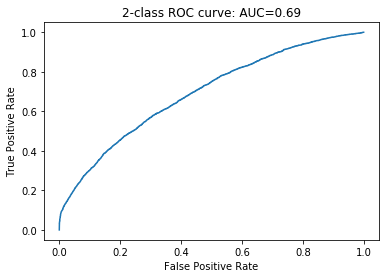

In [106]:
fpr, tpr, _ = metrics.roc_curve(target_test, probabilities_test)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('2-class ROC curve: AUC={0:0.2f}'.format(
          auc_score))
plt.show()

Overall our ROC curve indicates our model performs better than a naive guess, with an AUC=0.69. However, AUC is not always the best metric for unbalanced class cases such as this due to the inherent inbalance between false positives and true negatives in such a scenario. 

We will now turn to precision-recall curves. Precision-recall curves are valuable because, especially in the unbalanced class case, they give the practicioner a better sense of how well the model is representing the underpresented class.

In [107]:
average_precision = metrics.average_precision_score(target_test, probabilities_test)
print(average_precision)

0.3509579932267077


In [108]:
precision, recall, _ = metrics.precision_recall_curve(target_test, probabilities_test)

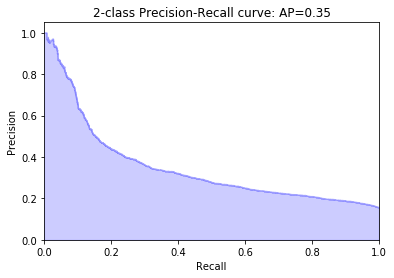

In [109]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

Here we find average precision over all possible decision thresholds to be .35. Overall this is lower than we would like, indicating a lot of false positives are being generated from our model. However, given the business case this may be more desirable than decreased recall and increased precision as was seen when tweaking our hyperparameters. 

### Final Model Comments

Overall our model did not seem to perform as well as hoped, even with hyper-parameter tuning and feature selection. There are several next steps that could be taken to improve the model, including:

1) Trying different classifiers aside from logistic regressions.  
2) Bringing in new features or datasets to improve precision/recall.  
3) Further exploring feature engineering in the given dataset.  
4) Gathering more data.

All of these steps could be used to help improve accuracy, precision, and recall rates of our model.